# Project 4: [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)





# Imports

In [1]:
import os
import psutil
import torchvision
!pip install pytorch-ignite
import ignite
import ignite.contrib.handlers
import ignite.engine
from ignite.engine import Events
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
!pip install transformers
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import time

#from pandas.core.missing import find_valid_index

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.1/264.1 KB 3.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.6 MB/s eta 0:00:00


In [2]:
%matplotlib inline
rand_seed = 42
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)
plt.ion()

In [3]:
force_use_cpu = False
if torch.cuda.is_available() and not force_use_cpu:    
    print(f"CUDA device available: {torch.cuda.get_device_name()}")
    use_cuda = True
    device = "cuda"
else:
    print(f"CUDA not available or disabled, using CPU.")
    use_cuda = False
    device = "cpu"
    
#cpu_cores = multiprocessing.cpu_count() # logische CPUs
cpu_cores = psutil.cpu_count(logical=False)
print(f"Available CPU cores: {cpu_cores}")

CUDA device available: Tesla T4
Available CPU cores: 1


# Data Preparation and cleaning

In [4]:
# !cp -r '/content/drive/MyDrive/Colab Notebooks' '/content'
# data = pd.read_csv("/content/Colab Notebooks/train.csv")
# labels = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
# test_data = pd.read_csv("/content/Colab Notebooks/test.csv")
# test_data.head()
# data.head()

In [5]:
# FOR EGI
# load dataset to working directory
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/Deep Learning')
!cp -r '/content/drive/Othercomputers/My Computer/Uni/22-23 WiSe/Pytorch Praktikum/4/Dataset' '/content'
data = pd.read_csv(os.path.join('/content', 'Dataset', 'train.csv'))

Mounted at /content/drive


In [6]:
data = pd.read_csv(os.path.join('/content', 'Dataset', 'train.csv'))

In [7]:
def clean_data (data, links=True,emojis=True,ip=True,css=True,html=True,dquotes=True,punct=True,schar=True,spaces=True,minimize_nontoxic=False):
    cleaned_data = data.copy()
    #print(clean_data)

    # Removing Hyperlinks from text beginning with http or https, followed by :// and one or more 
    # non-whitespace characters, beginning with www., followed by one or more non-whitespace characters. 
    if links:
        cleaned_data["comment_text"] = cleaned_data["comment_text"].map(lambda x: re.sub(r"https?://\S+|www\.\S+","",x) )

    # Removing emojis from text
    if emojis:
        cleaned_data["comment_text"] = cleaned_data["comment_text"].map(lambda x: re.sub("["
                                                                                      u"\U0001F600-\U0001F64F"
                                                                                      u"\U0001F300-\U0001F5FF"
                                                                                      u"\U0001F680-\U0001F6FF"
                                                                                      u"\U0001F1E0-\U0001F1FF"
                                                                                      u"\U00002702-\U000027B0"
                                                                                      u"\U000024C2-\U0001F251"
                                                                                      "]+","", x, flags=re.UNICODE))

    # Removing IP addresses from text 
    if ip:
        cleaned_data["comment_text"] = cleaned_data["comment_text"].map(lambda x: re.sub(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",x))


    # matches of css style,class elements and attributes
    if css:
        idxs_css = []
        for i in  range(len(cleaned_data)):
            if re.findall(r"[{][|].+\n",cleaned_data.loc[i,"comment_text"]):
                idxs_css.append(i)        
        cleaned_data.drop(idxs_css,inplace=True)

    # Removing html tags from text 
    if html:
        cleaned_data["comment_text"] = cleaned_data["comment_text"].map(lambda x: re.sub(r"<.*?>","",x))

    # Removing double quotes ""...""
    if dquotes:
        cleaned_data["comment_text"] = cleaned_data["comment_text"].map(lambda x: re.sub(r"\"\"", "\"",x))   # replacing "" with "
        cleaned_data["comment_text"] = cleaned_data["comment_text"].map(lambda x: re.sub(r"^\"", "",x))      # removing quotation from start and the end of the string
        cleaned_data["comment_text"] = cleaned_data["comment_text"].map(lambda x: re.sub(r"\"$", "",x))

    # Removing Punctuation / Special characters (;:'".?@!%&*+) which appears more than twice in the text 
    if punct:
        cleaned_data["comment_text"] = cleaned_data["comment_text"].map(lambda x: re.sub(r"[^a-zA-Z0-9\s][^a-zA-Z0-9\s]+", " ",x))

    # Removing Special characters 
    if schar:
        cleaned_data["comment_text"] = cleaned_data["comment_text"].map(lambda x: re.sub(r"[^a-zA-Z0-9\s\"\',:;?!.()]", " ",x))

    # Removing extra spaces in text
    if spaces:
        cleaned_data["comment_text"] = cleaned_data["comment_text"].map(lambda x: re.sub(r"\s\s+", " ",x))
  
    cleaned_data.reset_index(inplace=True)
    cleaned_data.drop(columns=["index"], inplace=True)
    
    # Keeping 15291 comments from non_toxic comments and dropping the rest
    if minimize_nontoxic:
        cleaned_data["total_classes"] = data.iloc[:,2:8].apply(lambda x: sum(x), axis=1)
        C_indexs = cleaned_data[cleaned_data["total_classes"]==0].index
        drop_indxs = np.random.choice(C_indexs, size=127696, replace=False)
        # Randomly selecting and dropping non_toxic comments from datasets and leaving 5000 behind
        cleaned_data.drop(drop_indxs, inplace=True)
    cleaned_data.reset_index(inplace=True,drop = True)  
    return cleaned_data

In [8]:
final_data = clean_data(data, minimize_nontoxic=True)
final_data

id                                       comment_text  \
0      00025465d4725e87   Congratulations from me as well, use the tool...   
1      0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK   
2      0005c987bdfc9d4b  Hey what is it talk .\nWhat is it an exclusive...   
3      0007e25b2121310b  Bye! Don't look, come or think of comming back...   
4      0009801bd85e5806  The Mitsurugi point made no sense why not argu...   
...                 ...                                                ...   
31508  ff7ef80ee62bbcf6  Thank you Squiddy! (but I still think it will ...   
31509  ffb47123b2d82762   Hey listen don't you ever Delete my edits eve...   
31510  ffbc2db4225258dd  While about half the references are from BYU I...   
31511  ffbd331a3aa269b9  I see this as having been merged; undoing one ...   
31512  fff125370e4aaaf3  And it looks like it was actually you who put ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate  \
0          0             0        0       0       0              0   
1          1             1        1       0       1              0   
2          1             0        0       0       0              0   
3          1             0        0       0       0              0   
4          0             0        0       0       0              0   
...      ...           ...      ...     ...     ...            ...   
31508      0             0        0       0       0              0   
31509      1             0        0       0       1              0   
31510      0             0        0       0       0              0   
31511      0             0        0       0       0              0   
31512      0             0        0       0       0              0   

       total_classes  
0                  0  
1                  4  
2                  1  
3                  1  
4                  0  
...              ...  
31508              0  
31509              0  
31510              1  
31511              0  
31512              3  

[31513 rows x 9 columns]

In [9]:
print("toxic: ", final_data["toxic"].sum())
print("severe toxic: ", final_data["severe_toxic"].sum())
print("obscene: ", final_data["obscene"].sum())
print("threat: ", final_data["threat"].sum())
print("insult: ", final_data["insult"].sum())
print("identity_hate: ", final_data["identity_hate"].sum())
print("clean comments: ", len(final_data[final_data["total_classes"] == 0]))
print("absolute nasty ass comments: ", len(final_data[final_data["total_classes"] == 6]))
print("total comments: ", len(final_data))

toxic:  3000
severe toxic:  297
obscene:  1665
threat:  98
insult:  1561
identity_hate:  268
clean comments:  15322
absolute nasty ass comments:  30
total comments:  31513


In [10]:
final_data

id                                       comment_text  \
0      00025465d4725e87   Congratulations from me as well, use the tool...   
1      0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK   
2      0005c987bdfc9d4b  Hey what is it talk .\nWhat is it an exclusive...   
3      0007e25b2121310b  Bye! Don't look, come or think of comming back...   
4      0009801bd85e5806  The Mitsurugi point made no sense why not argu...   
...                 ...                                                ...   
31508  ff7ef80ee62bbcf6  Thank you Squiddy! (but I still think it will ...   
31509  ffb47123b2d82762   Hey listen don't you ever Delete my edits eve...   
31510  ffbc2db4225258dd  While about half the references are from BYU I...   
31511  ffbd331a3aa269b9  I see this as having been merged; undoing one ...   
31512  fff125370e4aaaf3  And it looks like it was actually you who put ...   

       toxic  severe_toxic  obscene  threat  insult  identity_hate  \
0          0             0        0       0       0              0   
1          1             1        1       0       1              0   
2          1             0        0       0       0              0   
3          1             0        0       0       0              0   
4          0             0        0       0       0              0   
...      ...           ...      ...     ...     ...            ...   
31508      0             0        0       0       0              0   
31509      1             0        0       0       1              0   
31510      0             0        0       0       0              0   
31511      0             0        0       0       0              0   
31512      0             0        0       0       0              0   

       total_classes  
0                  0  
1                  4  
2                  1  
3                  1  
4                  0  
...              ...  
31508              0  
31509              0  
31510              1  
31511              0  
31512              3  

[31513 rows x 9 columns]

In [11]:
X_rest, X_test, Y_rest, Y_test = train_test_split(final_data.iloc[:,1], final_data.iloc[:,2:], test_size=0.1, stratify=final_data["total_classes"])
X_train, X_val, Y_train, Y_val = train_test_split(X_rest,Y_rest, test_size=0.1, stratify=Y_rest.iloc[:,-1])

Y_test.drop(columns=["total_classes"], inplace=True)
Y_train.drop(columns=["total_classes"], inplace=True)
Y_val.drop(columns=["total_classes"], inplace=True)

X_train = X_train.reset_index()
X_train.drop(columns=["index"], inplace=True)
Y_train = Y_train.reset_index()
Y_train.drop(columns=["index"], inplace=True)
X_test = X_test.reset_index()
X_test.drop(columns=["index"], inplace=True)
Y_test = Y_test.reset_index()
Y_test.drop(columns=["index"], inplace=True)
X_val = X_val.reset_index()
X_val.drop(columns=["index"], inplace=True)
Y_val = Y_val.reset_index()
Y_val.drop(columns=["index"], inplace=True)

In [12]:
def check_distribution_V(ytrain, yval, ytest):
    # creating new column named "sum" to show total num of classes comment belongs to
    y_train = ytrain.copy()
    y_val = yval.copy()
    y_test = ytest.copy()
    y_train["sum"] = y_train.iloc[:, :6].apply(lambda x: sum(x), axis=1) # here axis=1 means apply function is applied to each row
    y_val["sum"] = y_val.iloc[:, :6].apply(lambda x: sum(x), axis=1)
    y_test["sum"] = y_test.iloc[:, :6].apply(lambda x: sum(x), axis=1)
    
    # creating dict of ytrain and ytest to get total no of values in sum column
    dtrain = {}
    dval = {}
    dtest = {}
    for i,value in enumerate(y_train["sum"].value_counts()):
        dtrain[i] = value
    for i,value in enumerate(y_val["sum"].value_counts()):
        dval[i] = value
    for i,value in enumerate(y_test["sum"].value_counts()):
        dtest[i] = value
    
    # creating lists of keys and values for plotting distribution
    kTrlst= [key for key in dtrain.keys()]
    vTrlst = [key for key in dtrain.values()]
    kValst= [key for key in dval.keys()]
    vValst = [key for key in dval.values()]
    kTelst= [key for key in dtest.keys()]
    vTelst = [key for key in dtest.values()]
    
    # plotting distribution of dataset 
    plt.figure(figsize=(22,10))
    
    # Traning
    fr = plt.subplot(1,3,1)
    plt.bar(height=vTrlst,x=kTrlst, color="blue")
    fr.set_xlabel("Number of Classes comments belong to", fontsize=15)
    fr.set_ylabel("Total Number of Comments", fontsize=15)
    fr.set_title("Training Data", fontsize=17)
    for key in kTrlst:
        fr.annotate(s=dtrain[key], xy=(key,dtrain[key]), xycoords="data",size=13, ha="center")
    
    # Testing
    se = plt.subplot(1,3,2)
    plt.bar(height=vTelst,x=kTelst, color="red")
    se.set_xlabel("Number of Classes comments belong to", fontsize=15)
    se.set_ylabel("Total Number of Comments", fontsize=15)
    se.set_title("Testing Data", fontsize=17)
    for key in kTelst:
        se.annotate(s=dtest[key], xy=(key,dtest[key]), xycoords="data",size=13, ha="center")
     
    # Validation
    th = plt.subplot(1,3,3)
    plt.bar(height=vValst,x=kValst,  color="purple")
    th.set_xlabel("Number of Classes comments belong to", fontsize=15)
    th.set_ylabel("Total Number of Comments", fontsize=15)
    th.set_title("Validation Data", fontsize=17)
    for key in kValst:
        th.annotate(s=dval[key], xy=(key,dval[key]), xycoords="data",size=13, ha="center")

check_distribution_V(Y_train, Y_val, Y_test)

# Creating Dataset, Dataloader, and pre-trained BERT Model


In [13]:
from transformers import BertTokenizer
class toxic_dataset(Dataset):
  def __init__(self, sentences, labels):
    self.sentences = sentences
    self.labels = labels
    self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

  def __len__(self):
      return len(self.sentences)

  def __getitem__(self, idx):
    sentence = self.sentences.iloc[idx]["comment_text"]
    encoded_sentence = self.tokenizer.encode_plus(sentence, add_special_tokens = True, max_length = 200, padding = "max_length", truncation = True, return_attention_mask = True )
    tokens = torch.tensor(encoded_sentence["input_ids"], dtype = torch.long)
    mask = torch.tensor(encoded_sentence["attention_mask"], dtype = torch.long)
    toxic_label = torch.tensor(self.labels.iloc[idx], dtype = torch.float)

    return { "tokens": tokens, "mask": mask, "toxic_label": toxic_label}


In [14]:
# CREATING TRAIN/VALIDATION DATASET/LOADER
# PIN MEMORY TO HELP WITH SPEED OF TRANSFERRING DATA TO GPU

train_dataset = toxic_dataset(X_train, Y_train)
valid_dataset = toxic_dataset(X_val, Y_val)

train_batch = 32
valid_batch = 32

train_dataloader = DataLoader(train_dataset, batch_size = train_batch, pin_memory = True, num_workers = 4, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch, pin_memory = True, num_workers = 4, shuffle = False)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
# DISTILBERT BASE UNCASED MODEL GOES TO GPU

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 6)
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [16]:
# TESTING DATALOADER ON MODEL USING A SINGLE BATCH

# for a in train_dataloader:
#     tokens = a['tokens'].to(device)
#     mask = a['mask'].to(device)
#     output = model(tokens, mask)
#     break

# Running training without ignite

In [ ]:
epochs = 1
LR = 2e-5 #Learning rate
optimizer = AdamW(model.parameters(), LR, betas = (0.9, 0.999), weight_decay = 1e-2)#, correct_bias = False)
train_steps = int((len(train_dataset) * epochs)/train_batch)
num_steps = int(train_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)
loss_fn = nn.BCEWithLogitsLoss()
loss_fn.to(device)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    
    for a in train_dataloader:
        losses = []
        optimizer.zero_grad()
        
        #allpreds = []
        #alltargets = []
        
        with torch.cuda.amp.autocast():
            
            tokens = a['tokens'].to(device, non_blocking = True)
            mask = a['mask'].to(device, non_blocking = True) 

            output = model(tokens, mask) #This gives model as output, however we want the values at the output
            output = output['logits'].squeeze(-1).to(torch.float32)

            output_probs = torch.sigmoid(output)
            preds = torch.where(output_probs > 0.5, 1, 0)
            
            toxic_label = a['toxic_label'].to(device, non_blocking = True) 
            loss = loss_fn(output, toxic_label)            
            
            losses.append(loss.item())
            #allpreds.append(output.detach().cpu().numpy())
            #alltargets.append(toxic.detach().squeeze(-1).cpu().numpy())
            correct_predictions += torch.sum(preds == toxic_label)
        
        scaler.scale(loss).backward() #Multiplies (‘scales’) a tensor or list of tensors by the scale factor.
                                      #Returns scaled outputs. If this instance of GradScaler is not enabled, outputs are returned unmodified.
        scaler.step(optimizer) #Returns the return value of optimizer.step(*args, **kwargs).
        scaler.update() #Updates the scale factor.If any optimizer steps were skipped the scale is multiplied by backoff_factor to reduce it. 
                        #If growth_interval unskipped iterations occurred consecutively, the scale is multiplied by growth_factor to increase it
        scheduler.step() # Update learning rate schedule
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(train_dataset)*6)
    
    return losses, accuracy

In [ ]:
def validating(valid_dataloader, model):
    
    model.eval()
    correct_predictions = 0
    all_output_probs = []
    
    for a in valid_dataloader:
        losses = []
        tokens = a['tokens'].to(device, non_blocking = True)
        mask = a['mask'].to(device, non_blocking = True)
        output = model(tokens, mask)
        output = output['logits'].squeeze(-1).to(torch.float32)
        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0)
            
        toxic_label = a['toxic_label'].to(device, non_blocking = True)
        loss = loss_fn(output, toxic_label)
        losses.append(loss.item())
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        
        correct_predictions += torch.sum(preds == toxic_label)
        corr_preds = correct_predictions.detach().cpu().numpy()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(valid_dataset)*6)
    
    return losses, accuracy, all_output_probs

In [ ]:
from tqdm import tqdm 
best_score = 1000
train_accs = []
valid_accs = []
train_losses = []
valid_losses = []

for epoch in tqdm(range(epochs)):
    
    train_loss, train_acc = training(train_dataloader, model, optimizer, scheduler)
    valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
    
    print('train losses: %.4f' % train_loss, 'train accuracy: %.3f' % train_acc)
    print('valid losses: %.4f' % valid_loss, 'valid accuracy: %.3f' % valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
    
    if valid_loss < best_score:
        best_score = valid_loss
        print('Found a good model!')
        state = {
            'state_dict': model.state_dict(),
            'optimizer_dict': optimizer.state_dict(),
            'best_score': best_score
        }
        torch.save(state, 'best_model.pth')
    else:
        pass

# Plotting loss and accuracy

Text(0.5, 0.98, 'Losses and accuracy for 5 epochs')

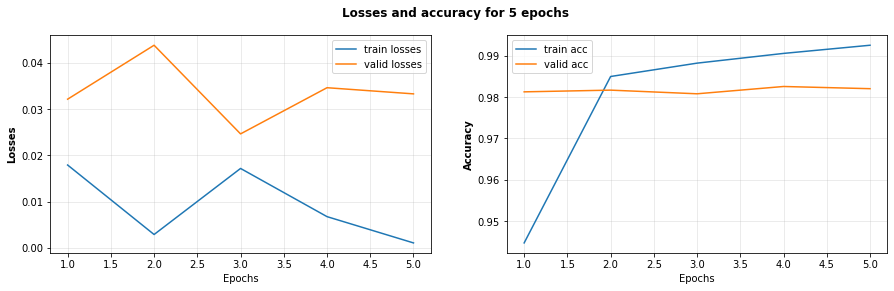

In [ ]:
x = range(1, epochs + 1)
fig, ax = plt.subplots(1, 2, figsize = (15,4))
ax[0].plot(x, train_losses)
ax[0].plot(x, valid_losses)
ax[0].set_ylabel('Losses', weight = 'bold')
ax[0].set_xlabel('Epochs')
ax[0].grid(alpha = 0.3)
ax[0].legend(labels = ['train losses', 'valid losses'])

ax[1].plot(x, train_accs)
ax[1].plot(x, valid_accs)
ax[1].set_ylabel('Accuracy', weight = 'bold')
ax[1].set_xlabel('Epochs')
ax[1].legend(labels = ['train acc', 'valid acc'])

ax[1].grid(alpha = 0.3)
fig.suptitle('Losses and accuracy for 5 epochs', weight = 'bold') 

# Testing on custom input (mostly for fun)

In [ ]:
# TESTING TRAINED MODEL ON OWN CHOICES
# CLASSES: toxic | severe_toxic | obscene | threat | insult | identity_hate	

to_translate = "that was by far the stupidest shit i've seen all my life"

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
encoded = tokenizer.encode_plus(to_translate)
token = torch.tensor([encoded["input_ids"]]).to(device)
mask = torch.tensor([encoded["attention_mask"]]).to(device)
output = model(token, mask)["logits"].squeeze(-1).to(torch.float32)
preds = torch.sigmoid(output)
preds = torch.where(preds > 0.5, 1, 0)
preds, output

(tensor([[1, 0, 1, 0, 0, 0]], device='cuda:0'),
 tensor([[ 2.9447, -3.7983,  2.7442, -4.7185, -0.6516, -5.1690]],
        device='cuda:0', grad_fn=<SqueezeBackward1>))

# Ignite

In [17]:
import time
from ignite.engine import Events


def build_training_system(model, optimizer, scheduler, loss_func, train_loader, val_loader):


  def train_step(trainer, batch):
    model.train()
    optimizer.zero_grad()
    with torch.cuda.amp.autocast():
        tokens = batch['tokens'].to(device, non_blocking = True)
        mask = batch['mask'].to(device, non_blocking = True) 

        output = model(tokens, mask) #This gives model as output, however we want the values at the output
        output = output['logits'].squeeze(-1).to(torch.float32)

        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0).to(device)
        
        toxic_label = batch['toxic_label'].to(device, non_blocking = True)
        loss = loss_func(output, toxic_label)
    
    scaler.scale(loss).backward() #Multiplies (‘scales’) a tensor or list of tensors by the scale factor.
                                  #Returns scaled outputs. If this instance of GradScaler is not enabled, outputs are returned unmodified.
    scaler.step(optimizer) #Returns the return value of optimizer.step(*args, **kwargs).
    scaler.update() #Updates the scale factor.If any optimizer steps were skipped the scale is multiplied by backoff_factor to reduce it. 
                    #If growth_interval unskipped iterations occurred consecutively, the scale is multiplied by growth_factor to increase it
    scheduler.step() # Update learning rate schedule
    return preds.float(), toxic_label

  def validation_step(engine, batch):
    model.eval()
    tokens = batch['tokens'].to(device, non_blocking = True)
    mask = batch['mask'].to(device, non_blocking = True)
    output = model(tokens, mask)
    output = output['logits'].squeeze(-1).to(torch.float32)
    output_probs = torch.sigmoid(output)
    preds = torch.where(output_probs > 0.5, 1, 0)
        
    toxic_label = batch['toxic_label'].to(device, non_blocking = True)
    loss = loss_func(output, toxic_label)
    return preds.float(), toxic_label
  
  def on_create_data(engine):
    self = engine.state
    columns = ["train_loss", "val_loss", "train_accuracy", "val_accuracy"]
    self.data = pd.DataFrame(np.nan, index = list(range(1, self.max_epochs + 1)), columns = columns)
    self.index = 1

  def on_evaluate_model(engine):
    self = engine.state
    self.evaluator.run(val_loader)
    self.data.at[self.index, "val_loss"] = self.evaluator.state.metrics["loss"]
    self.data.at[self.index, "val_accuracy"] = self.evaluator.state.metrics["accuracy"]
    self.data.at[self.index, "train_loss"] = self.metrics["train_loss"]
    self.data.at[self.index, "train_accuracy"] = self.metrics["train_accuracy"]
    self.index += 1

  def on_create_progressbar(engine):
    self = engine.state
    self.tqdm_logger = ignite.contrib.handlers.ProgressBar(persist = False)
    self.tqdm_logger.attach(engine)
  
  def on_create_timer(engine):
    self = engine.state
    self.start_time = time.time()
      
  def on_delete_timer(engine):
    self = engine.state
    elapsed_time = time.time() - self.start_time
    elapsed_time = time.strftime("%H hours %M minutes %S seconds", time.gmtime(elapsed_time))
    print(f"Finished in {elapsed_time}.")
  
  def on_output_metrics(engine):
    self = engine.state
    print(self.data)


  engine = ignite.engine.Engine(train_step)
  self = engine.state

  metrics = {
      "loss": ignite.metrics.Loss(loss_func),
      "accuracy": ignite.metrics.Accuracy()
  }

  self.evaluator = ignite.engine.Engine(validation_step)



  for name, metric in metrics.items():
    metric.attach(self.evaluator, name)

  accuracy_metric = ignite.metrics.Accuracy()
  accuracy_metric.attach(engine, "train_accuracy")
  loss_metric = ignite.metrics.Loss(loss_func)
  loss_metric.attach(engine, "train_loss")

  
  engine.add_event_handler(Events.STARTED, on_create_data)
  engine.add_event_handler(Events.EPOCH_COMPLETED, on_evaluate_model)
  engine.add_event_handler(Events.STARTED, on_create_progressbar)
  engine.add_event_handler(Events.STARTED, on_create_timer)
  engine.add_event_handler(Events.COMPLETED, on_output_metrics)
  engine.add_event_handler(Events.COMPLETED, on_delete_timer)
  return engine



In [18]:
epochs = 5
LR = 2e-5 #Learning rate
optimizer = AdamW(model.parameters(), LR, betas = (0.9, 0.999), weight_decay = 1e-2)#, correct_bias = False)
train_steps = int((len(train_dataset) * epochs)/train_batch)
num_steps = int(train_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)
loss_fn = nn.BCEWithLogitsLoss()
loss_fn
scaler = torch.cuda.amp.GradScaler()

trainer = build_training_system(model, optimizer, scheduler, loss_fn, train_dataloader, valid_dataloader)

In [19]:
_ = trainer.run(train_dataloader, max_epochs = epochs)

[1/798]   0%|           [00:00<?]

[1/798]   0%|           [00:00<?]

[1/798]   0%|           [00:00<?]

[1/798]   0%|           [00:00<?]

[1/798]   0%|           [00:00<?]

   train_loss  val_loss  train_accuracy  val_accuracy
1    0.708751  0.686763        0.944764      0.981260
2    0.686074  0.686296        0.984968      0.981671
3    0.684576  0.687915        0.988194      0.980790
4    0.683549  0.686173        0.990545      0.982552
5    0.682656  0.686684        0.992517      0.982023
Finished in 00 hours 13 minutes 11 seconds.


# ONXX Export

In [20]:
def export_model(model, filename):
  # prepare model for export
  model.eval()
  model = model.to('cpu')
  
  # create one sample input
  tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
  sample_input = tokenizer("This is a sample", return_tensors="pt")

  # export the model to onnx
  torch.onnx.export(
      model, 
      tuple(sample_input.values()),
      f = filename,  
      input_names = ['input_ids', 'attention_mask'], 
      output_names = ['logits'], 
      dynamic_axes = {'input_ids': {0: 'batch_size', 1: 'sequence'}, 
                    'attention_mask': {0: 'batch_size', 1: 'sequence'}, 
                    'logits': {0: 'batch_size', 1: 'sequence'}}, 
      do_constant_folding = True, 
      opset_version = 13, 
  )

export_model(model, filename = "model.onnx")

/usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/modeling_distilbert.py:218: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)
